In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-03-30 22:40:39.802366: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
import json

In [11]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [12]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 512, 512, 1) (2, 512, 512, 1)


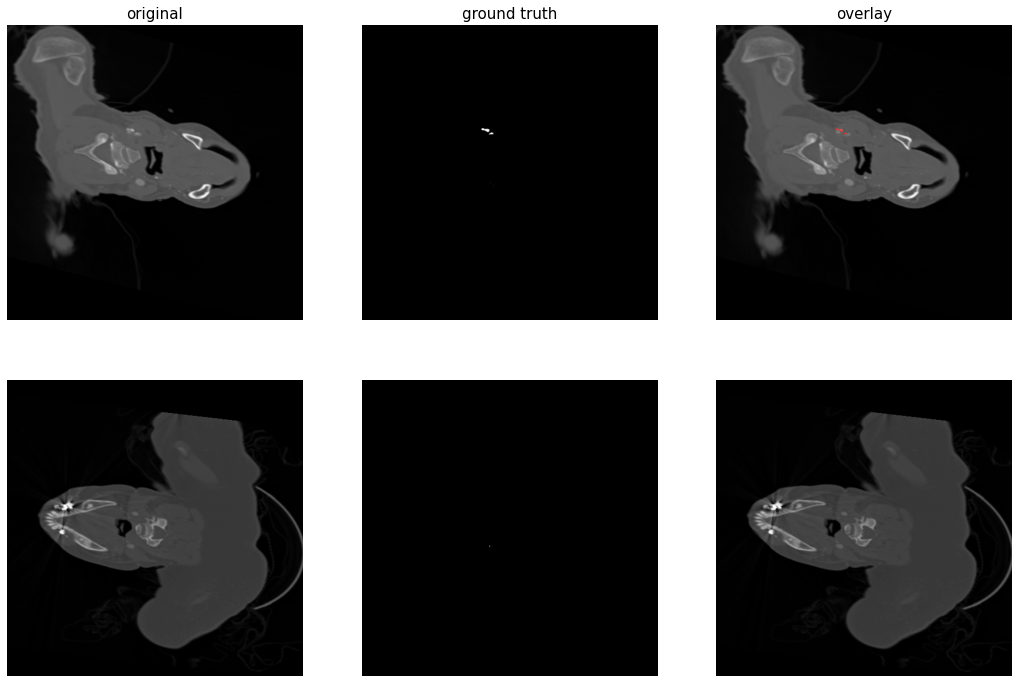

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-03-30 22:41:23.978839: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-30 22:41:24.040349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-30 22:41:24.040389: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-30 22:41:24.056953: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-30 22:41:24.056986: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-30 22:41:24.062588: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(), # Adam(learning_rate=lr_schedule)
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [18]:
history = model.fit(#X_train, 
                    #y_train, 
                    train_gen,
                    steps_per_epoch=50,
                    epochs=500,
                    validation_data=(X_val, y_val)) # callbacks = [earlystopping]

2023-03-30 22:42:35.668583: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-30 22:42:35.689171: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/500


2023-03-30 22:42:36.896139: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-30 22:42:37.649408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-30 22:42:38.567735: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-03-30 22:42:38.567761: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-03-30 22:42:38.568129: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-30 22:42:38.616302: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-30 22:42:39.561701: I tensorflow/stream_exec

50/50 [==============================] - 28s 389ms/step - loss: 0.1820 - iou: 0.0015 - iou_thresholded: 0.0054 - val_loss: 0.0179 - val_iou: 5.6009e-04 - val_iou_thresholded: 3.9424e-04
Epoch 2/500
50/50 [==============================] - 6s 124ms/step - loss: 0.0093 - iou: 0.0032 - iou_thresholded: 0.0084 - val_loss: 0.0057 - val_iou: 3.6886e-04 - val_iou_thresholded: 3.9424e-04
Epoch 3/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0083 - iou: 0.0023 - iou_thresholded: 0.0076 - val_loss: 0.0047 - val_iou: 4.3842e-04 - val_iou_thresholded: 3.9424e-04
Epoch 4/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0061 - iou: 0.0030 - iou_thresholded: 0.0091 - val_loss: 0.0057 - val_iou: 5.6506e-04 - val_iou_thresholded: 3.9424e-04
Epoch 5/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0066 - iou: 0.0030 - iou_thresholded: 0.0090 - val_loss: 0.0048 - val_iou: 5.9945e-04 - val_iou_thresholded: 3.9424e-04
Epoch 6/500
50/50 [=======

50/50 [==============================] - 6s 121ms/step - loss: 0.0038 - iou: 0.0160 - iou_thresholded: 0.0086 - val_loss: 0.0026 - val_iou: 0.0231 - val_iou_thresholded: 3.9377e-04
Epoch 44/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0030 - iou: 0.0187 - iou_thresholded: 0.0080 - val_loss: 0.0028 - val_iou: 0.0258 - val_iou_thresholded: 0.0013
Epoch 45/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0032 - iou: 0.0214 - iou_thresholded: 0.0093 - val_loss: 0.0022 - val_iou: 0.0253 - val_iou_thresholded: 3.9424e-04
Epoch 46/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0031 - iou: 0.0179 - iou_thresholded: 0.0071 - val_loss: 0.0025 - val_iou: 0.0262 - val_iou_thresholded: 3.9421e-04
Epoch 47/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0035 - iou: 0.0220 - iou_thresholded: 0.0095 - val_loss: 0.0021 - val_iou: 0.0277 - val_iou_thresholded: 3.9423e-04
Epoch 48/500
50/50 [===========================

Epoch 86/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0024 - iou: 0.0863 - iou_thresholded: 0.1267 - val_loss: 0.0025 - val_iou: 0.0728 - val_iou_thresholded: 0.2806
Epoch 87/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0023 - iou: 0.0901 - iou_thresholded: 0.1491 - val_loss: 0.0018 - val_iou: 0.0647 - val_iou_thresholded: 0.0240
Epoch 88/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0026 - iou: 0.0499 - iou_thresholded: 0.0585 - val_loss: 0.0016 - val_iou: 0.0783 - val_iou_thresholded: 0.1030
Epoch 89/500
50/50 [==============================] - 6s 125ms/step - loss: 0.0026 - iou: 0.0588 - iou_thresholded: 0.0602 - val_loss: 0.0016 - val_iou: 0.1031 - val_iou_thresholded: 0.1740
Epoch 90/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0026 - iou: 0.0944 - iou_thresholded: 0.1585 - val_loss: 0.0015 - val_iou: 0.1123 - val_iou_thresholded: 0.1238
Epoch 91/500
50/50 [==============================

Epoch 129/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0020 - iou: 0.1208 - iou_thresholded: 0.1679 - val_loss: 0.0014 - val_iou: 0.1536 - val_iou_thresholded: 0.3200
Epoch 130/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0021 - iou: 0.1473 - iou_thresholded: 0.2101 - val_loss: 0.0013 - val_iou: 0.1796 - val_iou_thresholded: 0.3611
Epoch 131/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0020 - iou: 0.1638 - iou_thresholded: 0.2803 - val_loss: 0.0011 - val_iou: 0.2277 - val_iou_thresholded: 0.4212
Epoch 132/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0020 - iou: 0.1019 - iou_thresholded: 0.1984 - val_loss: 0.0016 - val_iou: 0.0656 - val_iou_thresholded: 0.0338
Epoch 133/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0027 - iou: 0.1221 - iou_thresholded: 0.2439 - val_loss: 0.0012 - val_iou: 0.2108 - val_iou_thresholded: 0.3514
Epoch 134/500
50/50 [========================

Epoch 172/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0014 - iou: 0.1489 - iou_thresholded: 0.2066 - val_loss: 0.0011 - val_iou: 0.2216 - val_iou_thresholded: 0.3309
Epoch 173/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0016 - iou: 0.2200 - iou_thresholded: 0.3455 - val_loss: 8.0281e-04 - val_iou: 0.3158 - val_iou_thresholded: 0.4817
Epoch 174/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0021 - iou: 0.1821 - iou_thresholded: 0.2781 - val_loss: 0.0015 - val_iou: 0.1441 - val_iou_thresholded: 0.2928
Epoch 175/500
50/50 [==============================] - 6s 125ms/step - loss: 0.0020 - iou: 0.1280 - iou_thresholded: 0.2279 - val_loss: 8.8573e-04 - val_iou: 0.2619 - val_iou_thresholded: 0.4526
Epoch 176/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0019 - iou: 0.1633 - iou_thresholded: 0.2424 - val_loss: 9.9369e-04 - val_iou: 0.2369 - val_iou_thresholded: 0.4410
Epoch 177/500
50/50 [============

Epoch 215/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0026 - iou: 0.0863 - iou_thresholded: 0.1599 - val_loss: 0.0016 - val_iou: 0.1318 - val_iou_thresholded: 0.2437
Epoch 216/500
50/50 [==============================] - 6s 124ms/step - loss: 0.0028 - iou: 0.0629 - iou_thresholded: 0.0976 - val_loss: 0.0016 - val_iou: 0.1205 - val_iou_thresholded: 0.2059
Epoch 217/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0024 - iou: 0.0839 - iou_thresholded: 0.1186 - val_loss: 0.0017 - val_iou: 0.1217 - val_iou_thresholded: 0.2423
Epoch 218/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0024 - iou: 0.0800 - iou_thresholded: 0.1404 - val_loss: 0.0020 - val_iou: 0.1066 - val_iou_thresholded: 0.2705
Epoch 219/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0027 - iou: 0.0599 - iou_thresholded: 0.1084 - val_loss: 0.0016 - val_iou: 0.1204 - val_iou_thresholded: 0.2258
Epoch 220/500
50/50 [========================

Epoch 258/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0020 - iou: 0.0943 - iou_thresholded: 0.1610 - val_loss: 0.0014 - val_iou: 0.1464 - val_iou_thresholded: 0.2159
Epoch 259/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0018 - iou: 0.1092 - iou_thresholded: 0.1874 - val_loss: 0.0014 - val_iou: 0.1835 - val_iou_thresholded: 0.2572
Epoch 260/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0023 - iou: 0.1265 - iou_thresholded: 0.1998 - val_loss: 0.0016 - val_iou: 0.1465 - val_iou_thresholded: 0.3075
Epoch 261/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0026 - iou: 0.1010 - iou_thresholded: 0.1765 - val_loss: 0.0014 - val_iou: 0.1493 - val_iou_thresholded: 0.2556
Epoch 262/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0025 - iou: 0.0931 - iou_thresholded: 0.1654 - val_loss: 0.0015 - val_iou: 0.1353 - val_iou_thresholded: 0.2319
Epoch 263/500
50/50 [========================

Epoch 301/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0026 - iou: 0.1218 - iou_thresholded: 0.1905 - val_loss: 0.0017 - val_iou: 0.1461 - val_iou_thresholded: 0.3127
Epoch 302/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0025 - iou: 0.1050 - iou_thresholded: 0.1889 - val_loss: 0.0014 - val_iou: 0.1532 - val_iou_thresholded: 0.3037
Epoch 303/500
50/50 [==============================] - 6s 124ms/step - loss: 0.0019 - iou: 0.1234 - iou_thresholded: 0.2189 - val_loss: 0.0013 - val_iou: 0.1791 - val_iou_thresholded: 0.2794
Epoch 304/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0021 - iou: 0.1189 - iou_thresholded: 0.1916 - val_loss: 0.0013 - val_iou: 0.1626 - val_iou_thresholded: 0.2646
Epoch 305/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0018 - iou: 0.0826 - iou_thresholded: 0.1165 - val_loss: 0.0015 - val_iou: 0.1427 - val_iou_thresholded: 0.3031
Epoch 306/500
50/50 [========================

Epoch 344/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0022 - iou: 0.1407 - iou_thresholded: 0.2281 - val_loss: 0.0013 - val_iou: 0.1657 - val_iou_thresholded: 0.2222
Epoch 345/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0020 - iou: 0.1218 - iou_thresholded: 0.2196 - val_loss: 0.0013 - val_iou: 0.1735 - val_iou_thresholded: 0.2870
Epoch 346/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0019 - iou: 0.1090 - iou_thresholded: 0.1781 - val_loss: 0.0014 - val_iou: 0.1638 - val_iou_thresholded: 0.3314
Epoch 347/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0020 - iou: 0.1269 - iou_thresholded: 0.2366 - val_loss: 0.0015 - val_iou: 0.1530 - val_iou_thresholded: 0.3309
Epoch 348/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0022 - iou: 0.1252 - iou_thresholded: 0.2009 - val_loss: 0.0013 - val_iou: 0.1716 - val_iou_thresholded: 0.2734
Epoch 349/500
50/50 [========================

Epoch 387/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0019 - iou: 0.1227 - iou_thresholded: 0.1948 - val_loss: 0.0013 - val_iou: 0.1832 - val_iou_thresholded: 0.2264
Epoch 388/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0022 - iou: 0.1278 - iou_thresholded: 0.2428 - val_loss: 0.0012 - val_iou: 0.1838 - val_iou_thresholded: 0.3177
Epoch 389/500
50/50 [==============================] - 6s 126ms/step - loss: 0.0016 - iou: 0.1425 - iou_thresholded: 0.2141 - val_loss: 0.0013 - val_iou: 0.1787 - val_iou_thresholded: 0.2225
Epoch 390/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0020 - iou: 0.1171 - iou_thresholded: 0.1823 - val_loss: 0.0012 - val_iou: 0.1967 - val_iou_thresholded: 0.2982
Epoch 391/500
50/50 [==============================] - 6s 125ms/step - loss: 0.0018 - iou: 0.1355 - iou_thresholded: 0.2144 - val_loss: 0.0012 - val_iou: 0.2001 - val_iou_thresholded: 0.2601
Epoch 392/500
50/50 [========================

Epoch 430/500
50/50 [==============================] - 6s 124ms/step - loss: 0.0016 - iou: 0.1599 - iou_thresholded: 0.2868 - val_loss: 0.0011 - val_iou: 0.2144 - val_iou_thresholded: 0.3156
Epoch 431/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0018 - iou: 0.1377 - iou_thresholded: 0.1994 - val_loss: 0.0011 - val_iou: 0.1965 - val_iou_thresholded: 0.2825
Epoch 432/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0023 - iou: 0.1453 - iou_thresholded: 0.2414 - val_loss: 0.0012 - val_iou: 0.1956 - val_iou_thresholded: 0.2977
Epoch 433/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0017 - iou: 0.1620 - iou_thresholded: 0.2949 - val_loss: 0.0012 - val_iou: 0.2055 - val_iou_thresholded: 0.2470
Epoch 434/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0025 - iou: 0.1191 - iou_thresholded: 0.2034 - val_loss: 0.0012 - val_iou: 0.1702 - val_iou_thresholded: 0.2585
Epoch 435/500
50/50 [========================

Epoch 473/500
50/50 [==============================] - 6s 121ms/step - loss: 0.0019 - iou: 0.1330 - iou_thresholded: 0.2128 - val_loss: 0.0015 - val_iou: 0.1547 - val_iou_thresholded: 0.3276
Epoch 474/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0021 - iou: 0.1542 - iou_thresholded: 0.2511 - val_loss: 9.8948e-04 - val_iou: 0.2061 - val_iou_thresholded: 0.2605
Epoch 475/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0024 - iou: 0.0987 - iou_thresholded: 0.1909 - val_loss: 0.0011 - val_iou: 0.1976 - val_iou_thresholded: 0.2601
Epoch 476/500
50/50 [==============================] - 6s 120ms/step - loss: 0.0023 - iou: 0.1484 - iou_thresholded: 0.2346 - val_loss: 9.6954e-04 - val_iou: 0.2071 - val_iou_thresholded: 0.2548
Epoch 477/500
50/50 [==============================] - 6s 124ms/step - loss: 0.0017 - iou: 0.1421 - iou_thresholded: 0.2365 - val_loss: 9.2468e-04 - val_iou: 0.2051 - val_iou_thresholded: 0.2996
Epoch 478/500
50/50 [============

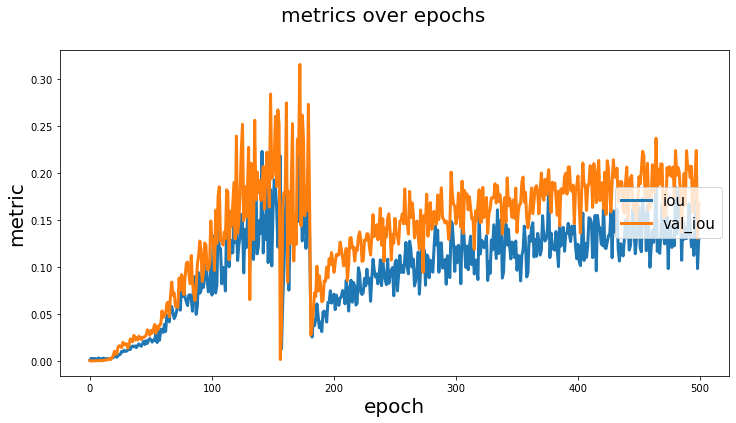

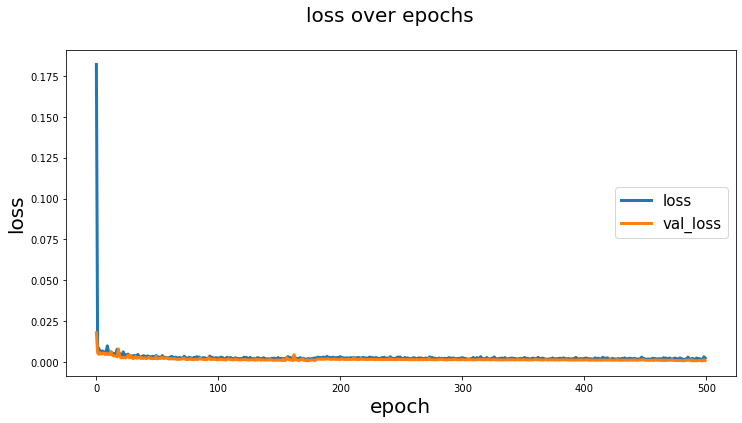

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_val)

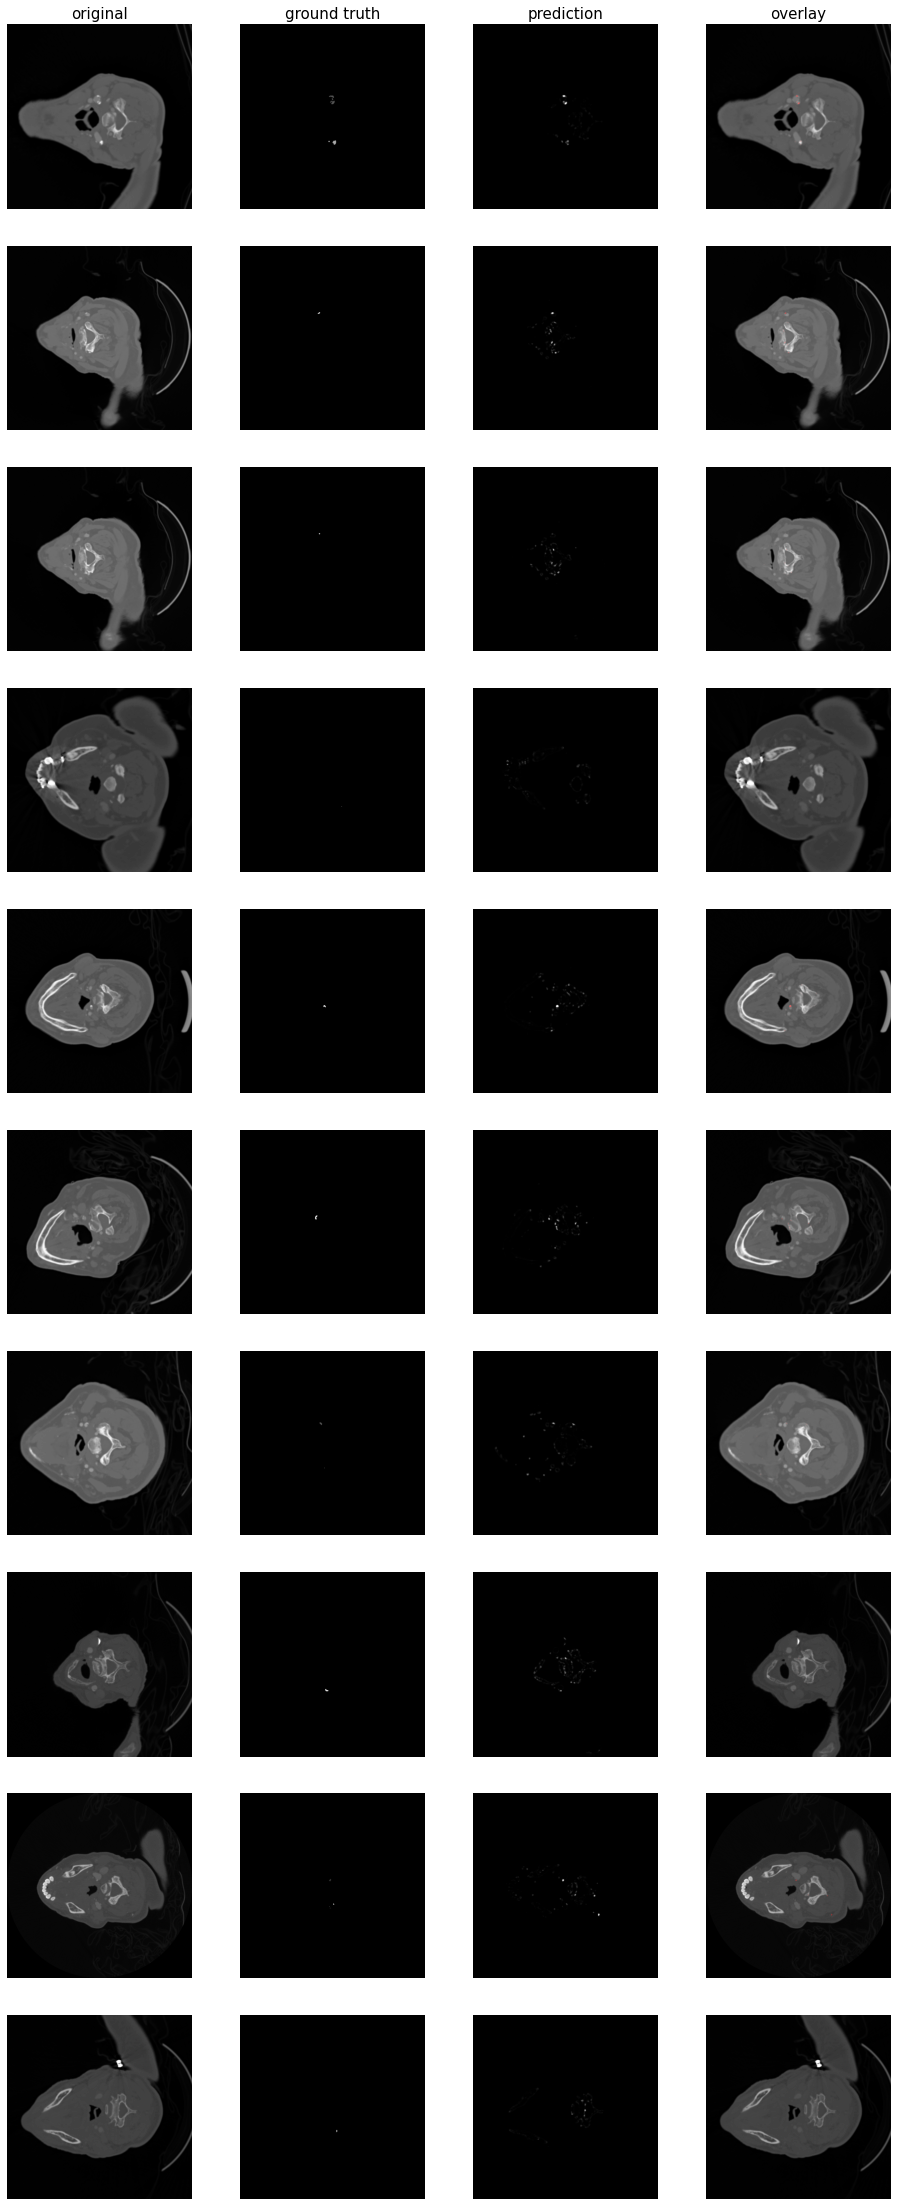

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 1s 188ms/step - loss: 9.6970e-04 - iou: 0.1680 - iou_thresholded: 0.3062
